In [1]:
import numpy as np

import operator

from functools import reduce

from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN

import plotly.graph_objects as go
from ipywidgets import widgets
# from IPython.display import display

In [2]:
from matplotlib import pyplot as plt

In [3]:
import networkx as nx

In [4]:
X = np.random.random((100,2))

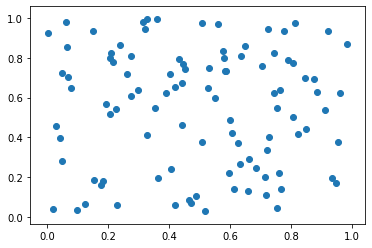

In [5]:
plt.scatter(x=X[:,0], y=X[:,1])

In [6]:
init_eps = 0.1
pipe = DBSCAN(eps=init_eps)
pipe.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [7]:
# eps_slider = widgets.FloatSlider(
#     value=init_eps,
#     min=0,
#     max=0.5,
#     step=0.01,
#     description='eps:',
#     disabled=False,
#     continuous_update=False,
# #     orientation='vertical',
#     readout=True,
#     readout_format='.2f',
# )

eps_text = widgets.FloatText(
    value=init_eps,
    step=0.1,
    description='eps:',
    disabled=False
)

container = widgets.HBox(children=[eps_text])

data = [go.Scatter(x=X[:,0],
                   y=X[:,1],
                   mode='markers',
                   marker=dict(color=pipe.labels_)
                  )
       ]

g = go.FigureWidget(data=data,
                    layout=go.Layout(
                        title=dict(
                            text='DBSCAN Clustering'
                        ),
                        barmode='overlay'
                    ))

valid = widgets.Valid(
    value=True,
    description='Valid params',
)

In [8]:
def response(change):
    try:
        pipe.set_params(eps=eps_text.value)
        labels = pipe.fit_predict(X)
        with g.batch_update():
            if not valid.value:
                g.data[0].x = X[:, 0]
                g.data[0].y = X[:, 1]
            g.data[0].marker = dict(color=labels)
        valid.value = True
    except ValueError:
        with g.batch_update():
            g.data[0].x = []
            g.data[0].y = []
            marker=dict()
        valid.value = False

eps_text.observe(response, names="value")

In [9]:
widgets.VBox([container, g, valid])

    'data'…

# Now with Mapper

In [10]:
from giotto.mapper.mapper import make_mapper_pipeline

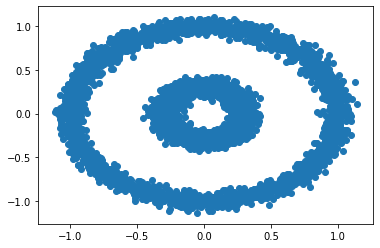

In [11]:
data, labels = make_circles(n_samples=5000, noise=0.05, factor=0.3)

plt.scatter(data[:,0], data[:, 1]);

In [12]:
pipe = make_mapper_pipeline()

In [13]:
def create_network_2d(graph, pos, node_size, node_color, node_text,
                      node_scale=12, colorscale='viridis', cmin=0, cmax=1,
                      legend_title=''):

    edge_x = list(reduce(operator.iconcat,
                         map(lambda x: [pos[x[0]][0],
                                        pos[x[1]][0], None],
                             graph.edges()), []))
    edge_y = list(reduce(operator.iconcat,
                         map(lambda x: [pos[x[0]][1],
                                        pos[x[1]][1], None],
                             graph.edges()), []))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [pos[k][0] for k in graph.nodes()]
    node_y = [pos[k][1] for k in graph.nodes()]

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale=colorscale,
            reversescale=True,
            line=dict(width=.5, color='#888'),
            color=node_color,
            size=node_size,
            sizemode='area',
            sizeref=2.*max(node_size)/(node_scale**2),
            sizemin=4,
            cmin=cmin,
            cmax=cmax,
            colorbar=dict(
                thickness=15,
                title=legend_title,
                xanchor='left',
                titleside='right'
            ),
            line_width=2),
        text=node_text)

    fig = go.FigureWidget(data=[edge_trace, node_trace],
                    layout=go.Layout(showlegend=False,
                                     hovermode='closest',
                                     margin={'b': 20, 'l': 5, 'r': 5, 't': 40},
                                     xaxis=dict(showgrid=False, zeroline=False,
                                                showticklabels=False, ticks="",
                                                showline=False),
                                     yaxis=dict(showgrid=False, zeroline=False,
                                                showticklabels=False, ticks="",
                                                showline=False),
                                     xaxis_title="",
                                     yaxis_title=""))
    fig.update_layout(template='simple_white')

    return fig

In [14]:
# graph = pipe.fit_transform(data)

# node_elements = nx.get_node_attributes(graph, 'elements')
# node_sizes = [len(el) for el in node_elements.values()]
# node_colors = [np.mean(data[el]) for el in node_elements.values()]
# node_text = [k for k in node_elements.keys()]


# pos = nx.kamada_kawai_layout(graph, dim=2)

# fig = create_network_2d(graph, pos, node_sizes, node_colors, node_sizes, node_scale=20)

# fig.show()

## Iteration 1: Interactivity for giotto-learn--specific transformers

## 1.1: OneDimensionalCover

In [15]:
cover_params = {key: item for key, item in pipe.get_mapper_params().items() if key.startswith('cover')}

cover_params_widgets = {}
for param, value in cover_params.items():
    if isinstance(value, float):
        cover_params_widgets[param] = widgets.FloatText(
            value=value,
            step=0.1,
            description=param,
            disabled=False
        )
    if isinstance(value, int):
        cover_params_widgets[param] = widgets.IntText(
            value=value,
            description=param,
            disabled=False
        )

container = widgets.HBox(children=list(cover_params_widgets.values()))

# data = [go.Scatter(x=X[:,0],
#                    y=X[:,1],
#                    mode='markers',
#                    marker=dict(color=pipe.labels_)
#                   )
#        ]

def fn(data):
    graph = pipe.fit_transform(data)
    node_elements = nx.get_node_attributes(graph, 'elements')
    node_sizes = [len(el) for el in node_elements.values()]
    node_colors = [np.mean(data[el]) for el in node_elements.values()]
    node_text = [k for k in node_elements.keys()]

    pos = nx.kamada_kawai_layout(graph, dim=2)

    return create_network_2d(graph, pos, node_sizes, node_colors, node_sizes, node_scale=20)

g = fn(data)    
    
valid = widgets.Valid(
    value=True,
    description='Valid params',
)

In [16]:
del response

In [17]:
def response(change):
#     try:
    pipe.set_mapper_params(cover__n_intervals=cover_params_widgets['cover__n_intervals'].value)
    pipe.set_mapper_params(cover__overlap_frac=cover_params_widgets['cover__overlap_frac'].value)
    new_g = fn(data)
    with g.batch_update():
#             if not valid.value:
#                 g.data[0].x = X[:, 0]
#                 g.data[0].y = X[:, 1]
#         g.data = new_g.data #.data[0].marker = dict(color=labels)
        g.data[0].x = new_g.data[0].x
        g.data[0].y = new_g.data[0].y
        g.data[1].x = new_g.data[1].x
        g.data[1].y = new_g.data[1].y
        g.data[1].marker.size = new_g.data[1].marker.size
        g.data[1].marker.color = new_g.data[1].marker.color
        g.data[1].marker.sizeref = new_g.data[1].marker.sizeref
    valid.value = True
#     except ValueError:
#         with g.batch_update():
#             g.data[0].x = []
#             g.data[0].y = []
#             marker=dict()
#         valid.value = False

cover_params_widgets['cover__n_intervals'].observe(response, names="value")
cover_params_widgets['cover__overlap_frac'].observe(response, names="value")

In [18]:
widgets.VBox([container, g, valid])